# Comparing meteorological forcing from ERA5 and GSWP3

We've included two different datasets that can drive ELM simulations

In [48]:
# Script to plot and compare meteorological data across ERA5 and GSWP3.
# ELM when run independently needs several meterological inputs

import xarray as xr
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import pandas as pd

# define a function that will return the file name of requested met data
def get_site_file(site_name: str, met_source: str, variable: str) -> str:
    """
    Get file path for a given site, meteorological source, and variable.
    
    Parameters:
    -----------
    site_name : str
        Name of the site (e.g., 'beo', 'council', 'toolik_lake')
    met_source : str
        Meteorological data source, either 'era5' or 'gswp3'
    variable : str
        Meteorological variable: 'TBOT', 'QBOT', 'PRECTmms', 'FSDS', 'FLDS', 'WIND', or 'PSRF'
    
    Returns:
    --------
    str
        The full path to the file
    """
    
    # Valid variables
    valid_vars = ['TBOT', 'QBOT', 'PRECTmms', 'FSDS', 'FLDS', 'WIND', 'PSRF']
    if variable not in valid_vars:
        raise ValueError(f"Invalid variable: {variable}. Must be one of {valid_vars}")
    
    # Define met_root based on source
    if met_source == 'era5':
        met_root = "/mnt/inputdata/E3SM/atm/datm7/era5"
    elif met_source == 'gswp3':
        met_root = "/mnt/inputdata/E3SM/atm/datm7/gswp3"
    else:
        raise ValueError(f"Invalid met_source: {met_source}. Must be 'era5' or 'gswp3'")
    
    # Site configurations
    sites = {
        'beo': {
            'met_path': f"{met_root}/utq"
        },
        'council': {
            'met_path': f"{met_root}/cnl"
        },
        'kougarok': {
            'met_path': f"{met_root}/kg"
        },
        'teller': {
            'met_path': f"{met_root}/tl"
        },
        'toolik_lake': {
            'met_path': f"{met_root}/tfs"
        },
        'trail_valley_creek': {
            'met_path': f"{met_root}/tvc"
        },
        'abisko': {
            'met_path': f"{met_root}/abs"
        },
        'bayelva': {
            'met_path': f"{met_root}/bs"
        },
        'samoylov_island': {
            'met_path': f"{met_root}/si"
        },
        'upper_kuparuk': {
            'met_path': f"{met_root}/UpK_wshed" if met_source == 'era5' else f"{met_root}/tfs"
        },
        'imnaviat_creek': {
            'met_path': f"{met_root}/ImC_wshed" if met_source == 'era5' else f"{met_root}/tfs"
        }
    }
    
    if site_name not in sites:
        raise ValueError(f"Invalid site_name: {site_name}")
    
    site_config = sites[site_name]

    if met_source == 'era5':
        # Return the full path with variable-specific filename
        pattern = f"{site_config['met_path']}/ERA5_{variable}_1950-2024_*.nc"
        match = glob.glob(pattern)
    else:
        pattern = f"{site_config['met_path']}/GSWP3_{variable}_1901-2014_*.nc"
        match = glob.glob(pattern)

    if match:
        filepath = match[0]  # Get first match
    else:
        print("Met data not found - recommend checking two things:")
        print("1) Did you run the get_inputdata.sh script in the ")
        print("   setup instructions in the model container?")
        print("2) Was the container started in the correct location,")
        print("   and with the right volume mounts?")
        raise FileNotFoundError(f"No files found matching: {pattern}")

    return filepath


In [68]:
# set site and variable and load file:

site = "imnaviat_creek"
variable = "QBOT" # [ TBOT, PRECTmms, QBOT, PSRF, FSDS, FLDS, WIND ]

era5_data = xr.open_dataset(get_site_file(site,"era5",variable),engine="netcdf4").load().sel(n=0)
gswp3_data = xr.open_dataset(get_site_file(site,"gswp3",variable),engine="netcdf4").load().sel(n=0)

# calendar encoding in ERA5 still seems to be a bit different
era5_data = era5_data.convert_calendar('standard', dim = "DTIME", use_cftime=False)

In [69]:
# let's take a look a shorter period of time for simplicity - so we can 'slice' these arrays to subset a time
era5_data_slice = era5_data.sel(DTIME=slice("1980-01-01","2010-01-01"))
gswp3_data_slice = gswp3_data.sel(DTIME=slice("1980-01-01","2010-01-01"))

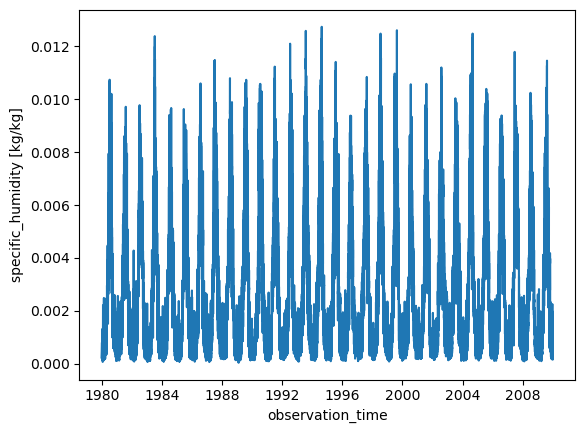

In [70]:
era5_data_slice[variable].plot()

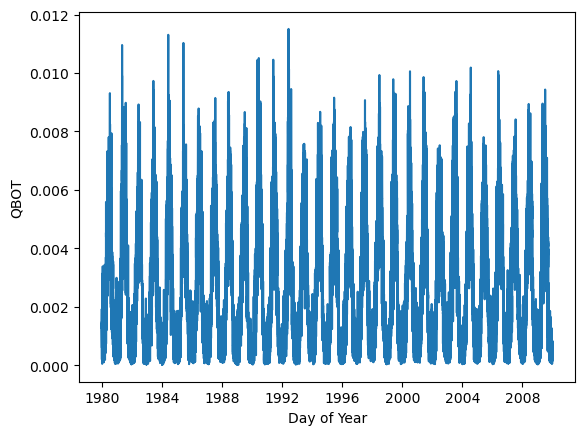

In [71]:
gswp3_data_slice[variable].plot()

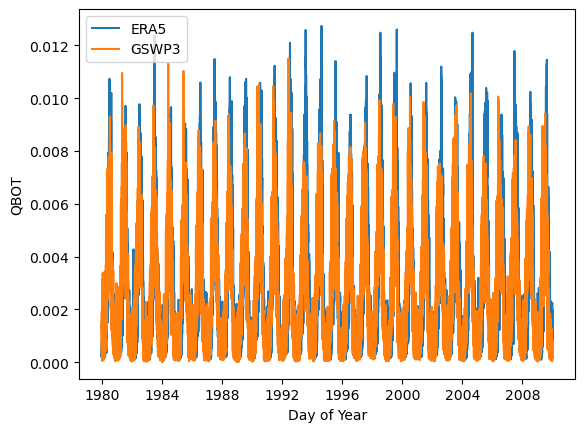

In [72]:
# we can also plot these on the same axes:
fig, ax = plt.subplots()
era5_data_slice[variable].plot(ax=ax, label='ERA5')
gswp3_data_slice[variable].plot(ax=ax, label='GSWP3')
ax.legend()
plt.show()

/tmp/ipykernel_9696/1769461355.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',


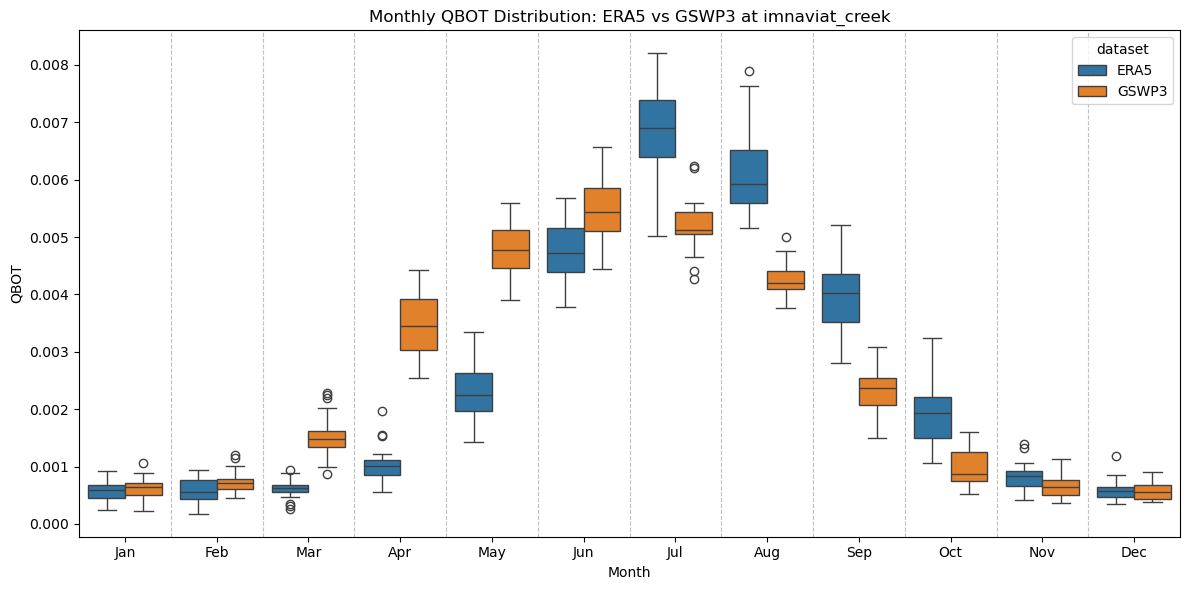

In [73]:
# now look at the annual cycle

# Resample to monthly averages
era5_monthly = era5_data_slice[variable].resample(DTIME='1ME').mean()
gswp3_monthly = gswp3_data_slice[variable].resample(DTIME='1ME').mean()

# Add a month coordinate (1-12) for grouping
era5_monthly = era5_monthly.assign_coords(month=era5_monthly['DTIME'].dt.month)
gswp3_monthly = gswp3_monthly.assign_coords(month=gswp3_monthly['DTIME'].dt.month)


# Convert to pandas and add month column
era5_df = era5_monthly.to_dataframe(name=variable).reset_index()
era5_df['month'] = era5_df['DTIME'].dt.month
era5_df['dataset'] = 'ERA5'

gswp3_df = gswp3_monthly.to_dataframe(name=variable).reset_index()
gswp3_df['month'] = gswp3_df['DTIME'].dt.month
gswp3_df['dataset'] = 'GSWP3'

# Combine dataframes
combined = pd.concat([era5_df[['month', variable, 'dataset']], 
                      gswp3_df[['month', variable, 'dataset']]])

fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=combined, x='month', y=variable, hue='dataset', ax=ax)
# Add vertical dashed lines between months
for i in range(1, 12):  # Lines between months 1-2, 2-3, ..., 11-12
    ax.axvline(x=i - 0.5, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
ax.set_title(f'Monthly {variable} Distribution: ERA5 vs GSWP3 at {site}')
ax.set_xlabel('Month')
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()
